In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/massive-yahoo-finance-dataset/stock_details_5_years.csv


In [2]:
file_path = "/kaggle/input/massive-yahoo-finance-dataset/stock_details_5_years.csv"
df = pd.read_csv(file_path)

# Convert "Date" column to datetime
df['Date'] = pd.to_datetime(df['Date'], utc = True)

df = df.sort_values(by = "Date")

# Check for any missing values
print("Missing Values:\n", df.isnull().sum())

df.head(5)

Missing Values:
 Date            0
Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
Company         0
dtype: int64


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Company
0,2018-11-29 05:00:00+00:00,43.829761,43.863354,42.639594,43.083508,167080000,0.0,0.0,AAPL
312,2018-11-29 05:00:00+00:00,75.903743,76.029017,75.142496,75.450851,466800,0.0,0.0,WCN
311,2018-11-29 05:00:00+00:00,56.789875,56.789875,56.789875,56.789875,300,0.0,0.0,FERG
310,2018-11-29 05:00:00+00:00,37.257999,37.367001,36.585999,37.042999,1853000,0.0,0.0,CSGP
309,2018-11-29 05:00:00+00:00,13.439500,14.347000,13.439500,14.081000,15479000,0.0,0.0,TTD


In [3]:
# Sort date by company and date
if 'Company' in df.index.names:
    df = df.reset_index(drop = True)
df = df.sort_values(by=['Company', 'Date'])

# Calculate indicators per company
def compute_indicators(group):
    group['SMA_10'] = group['Close'].rolling(window = 10, min_periods = 1).mean()
    group['EMA_10'] = group['Close'].ewm(span = 10, adjust = False).mean()

    # RSI
    delta = group['Close'].diff().fillna(0)
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    avg_gain = pd.Series(gain).rolling(window = 14, min_periods = 1).mean()
    avg_loss = pd.Series(loss).rolling(window = 14, min_periods = 1).mean()
    rs = avg_gain / avg_loss
    group['RSI_14'] = 100 - (100 / (1 + rs))
    
    # Bollinger Bands
    rolling_mean = group['Close'].rolling(window = 20, min_periods = 1).mean()
    rolling_std = group['Close'].rolling(window = 20, min_periods = 1).std()
    group['Bollinger_Upper'] = rolling_mean + (rolling_std * 2)
    group['Bollinger_Lower'] = rolling_mean - (rolling_std * 2)

    return group

# Apply for each Company
df = df.groupby('Company', group_keys = False).apply(compute_indicators)

df = df.reset_index(drop=True)

<ipython-input-3-e4588c5db007>:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Company', group_keys = False).apply(compute_indicators)


In [4]:
from sklearn.ensemble import IsolationForest

# Initialize Isolation Forset
iso_forest = IsolationForest(n_estimators = 100, contamination = 0.01, random_state = 42)

# Select features for anomaly detection
features = ['Close', 'SMA_10', 'EMA_10', 'RSI_14', 'Bollinger_Upper', 'Bollinger_Lower']
df_anomaly = df[features].fillna(0)

# Fit the Model
df['anomaly_score'] = iso_forest.fit_predict(df_anomaly)

# Label anomalies(anomaly = -1, normal = 1)
df['is_anomaly'] = df['anomaly_score'].apply(lambda x: 1 if x == -1 else 0)

# Number of anomalies
print("Number of Anomalies Detected: ", df['is_anomaly'].sum())

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Number of Anomalies Detected:  6028


In [5]:
# Check for the companies having anomalies
anomaly_counts = df[df['is_anomaly'] == 1]['Company'].value_counts()
anomaly_counts.head(10)

Company
BKNG     1257
NVR      1257
AZO      1109
CMG       873
MTD       758
MELI      631
FCNCA     143
Name: count, dtype: int64

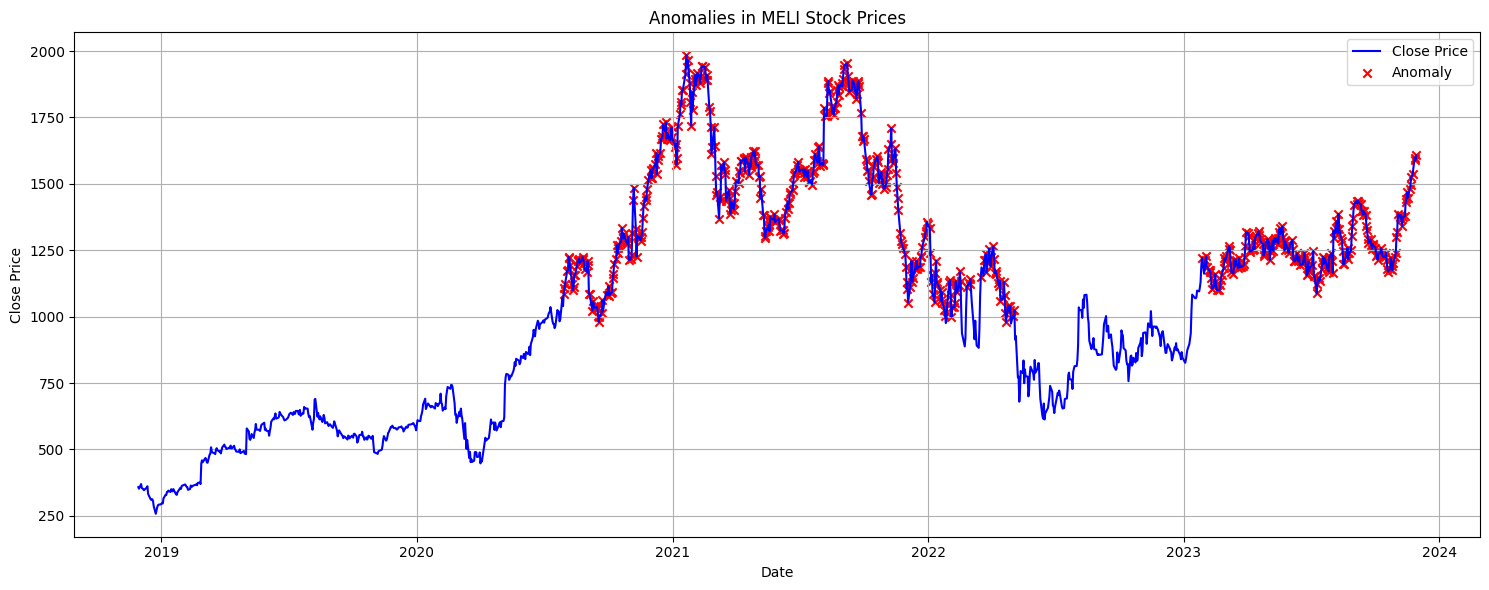

is_anomaly
1    631
0    627
Name: count, dtype: int64


In [6]:
# Plot the anomalies for different companies
import matplotlib.pyplot as plt

# Select a company
company_name = 'MELI'
company_df = df[df['Company'] == company_name]

# Plot
plt.figure(figsize = (15, 6))
plt.plot(company_df['Date'], company_df['Close'], label = 'Close Price', color = 'blue')
anomalies = company_df[company_df['is_anomaly'] == 1]
plt.scatter(anomalies['Date'], anomalies['Close'], 
            color = 'red', label = 'Anomaly', marker = 'x')

plt.title(f"Anomalies in {company_name} Stock Prices")
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(company_df['is_anomaly'].value_counts())

10:09:32 - cmdstanpy - INFO - Chain [1] start processing
10:09:32 - cmdstanpy - INFO - Chain [1] done processing


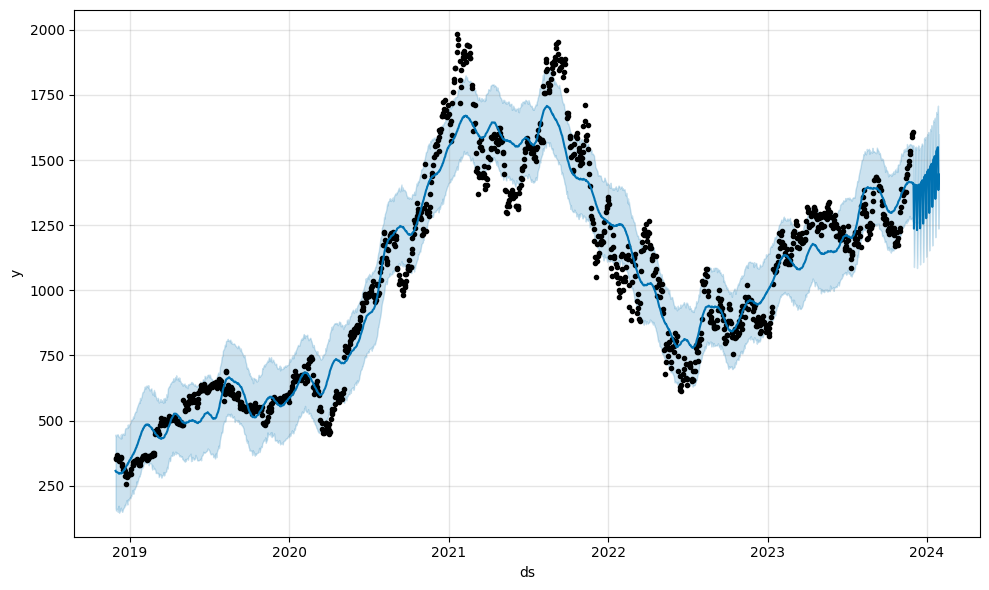

In [7]:
from prophet import Prophet

meli_df = df[df['Company'] == 'MELI'][['Date', 'Close']].copy()
meli_df = meli_df.rename(columns = {'Date': 'ds', 'Close': 'y'})

# Remove timezone info
meli_df['ds'] = meli_df['ds'].dt.tz_localize(None)

# Initialize and fit model Prophet
model = Prophet()
model.fit(meli_df)

# Make dataframe fot the next 60 days
future = model.make_future_dataframe(periods = 60)
forecast = model.predict(future)

fig = model.plot(forecast)

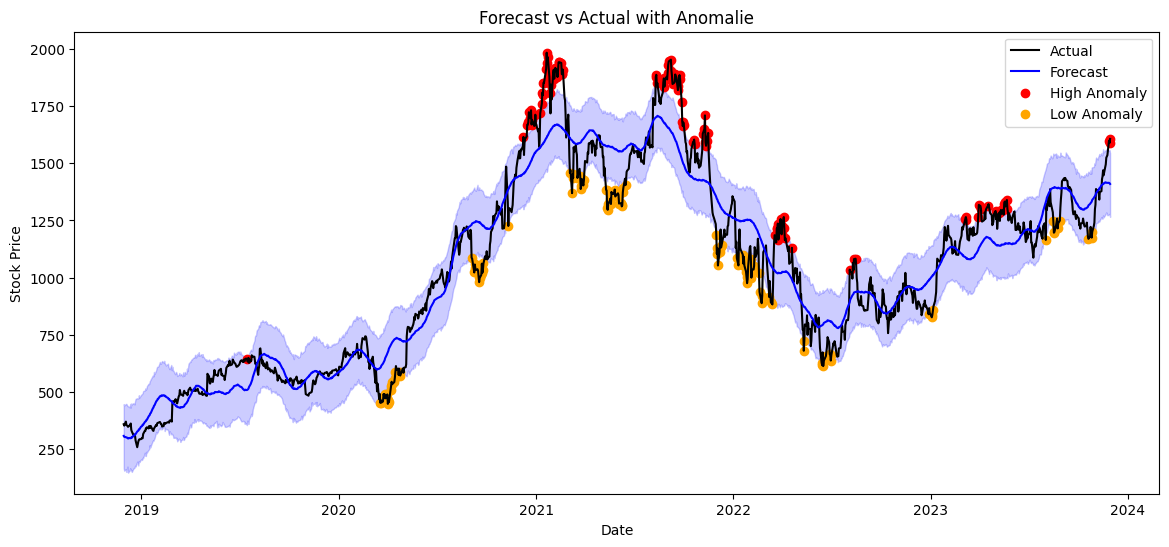

In [8]:
# Merge actuals with forecast
forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
merged = pd.merge(meli_df, forecast, on='ds')

# Define anomaly where actual 'y' is outside the confidence bounds
merged['forecast_anomaly'] = 0
merged.loc[merged['y'] > merged['yhat_upper'], 'forecast_anomaly'] = 1  # Higher than expected
merged.loc[merged['y'] < merged['yhat_lower'], 'forecast_anomaly'] = -1  # Lower than expected

# Plot anomalies
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(merged['ds'], merged['y'], label='Actual', color='black')
plt.plot(merged['ds'], merged['yhat'], label='Forecast', color='blue')
plt.fill_between(merged['ds'], merged['yhat_lower'], merged['yhat_upper'], color='blue', alpha=0.2)

# Mark anomalies
plt.scatter(merged[merged['forecast_anomaly'] == 1]['ds'], 
            merged[merged['forecast_anomaly'] == 1]['y'], 
            color='red', label='High Anomaly')

plt.scatter(merged[merged['forecast_anomaly'] == -1]['ds'], 
            merged[merged['forecast_anomaly'] == -1]['y'], 
            color='orange', label='Low Anomaly')

plt.legend()
my_title = "Forecast vs Actual with Anomalie"
plt.title(my_title)
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()
